In [21]:
import os, subprocess
import json
import uproot
import awkward as ak
import numpy as np
from coffea import processor, util, hist

%matplotlib inline
from matplotlib import lines as mlines
import matplotlib.pyplot as plt
from cycler import cycler

In [22]:
lumis = {}
lumis['2016'] = 35.9
lumis['2017'] = 41.5
lumis['2018'] = 59.9

nfiles_mc = {}
nfiles_mc['2016'] = 64
nfiles_mc['2017'] = 89
nfiles_mc['2018'] = 106

nfiles_data = {}
nfiles_data['2016'] = 16
nfiles_data['2017'] = 19
nfiles_data['2018'] = 27

with open('xsec.json') as f:
  xs = json.load(f)

with open('pmap.json') as f:
  pmap = json.load(f)

In [23]:
year = '2016'
outsum = processor.dict_accumulator()

In [24]:
# Load all MC
for n in range(1,nfiles_mc[year]+1):
    print(n)
    filename = 'condor/outfiles/'+year+'_'+str(n)+'.coffea'
    if os.path.isfile(filename):
        out = util.load(filename)
        outsum.add(out)
    else:
        print("File " + filename + " is missing")
        
scale_lumi = {k: xs[k] * 1000 *lumis[year] / w for k, w in outsum['sumw'].items()}
outsum['templates1'].scale(scale_lumi, 'dataset')
outsum['templates2'].scale(scale_lumi, 'dataset')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64


In [25]:
# Load all data
for n in range(1,nfiles_data[year]+1):
    print(n)
    filename = 'condor/outdata/'+year+'_'+str(n)+'.coffea'
    if os.path.isfile(filename):
        out = util.load(filename)
        outsum.add(out)
    else:
        print("File " + filename + " is missing")
        
# BE CAREFUL NOT TO UNBLIND
# Can you figure out how to blind it at this step???

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


In [26]:
templates_mjj = outsum['templates2'].group('dataset', hist.Cat('process', 'Process'), pmap)
templates_pt = outsum['templates1'].group('dataset', hist.Cat('process', 'Process'), pmap)

/uscms/home/jennetd/.local/lib/python3.6/site-packages/coffea/hist/hist_tools.py:346: RuntimeWarning: Not all requested indices present in <Cat (name=dataset) instance at 0x7f5bffc395f8>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)
/uscms/home/jennetd/.local/lib/python3.6/site-packages/coffea/hist/hist_tools.py:346: RuntimeWarning: Not all requested indices present in <Cat (name=dataset) instance at 0x7f5c00baa390>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)


In [27]:
templates_mjj = templates_mjj.sum('qgl1','qgl2').integrate('deta',int_range=slice(3.5,7))
templates_pt = templates_pt.integrate('mjj',int_range=slice(1000,4000)).integrate('deta',int_range=slice(3.5,7))

In [28]:
os.system('rm '+year+'/1-signalregion.root')
fout = uproot.create(year+'/1-signalregion.root')
for p in pmap.keys():  
    h = templates_pt.integrate('region', 'signal').sum('pt1').integrate('ddb1',int_range=slice(0.89,1)).integrate('process',p)
    fout[p+"_pass"] = hist.export1d(h)
    h = templates_pt.integrate('region', 'signal').sum('pt1').integrate('ddb1',int_range=slice(0,0.89)).integrate('process',p)
    fout[p+"_fail"] = hist.export1d(h)

fout.close()

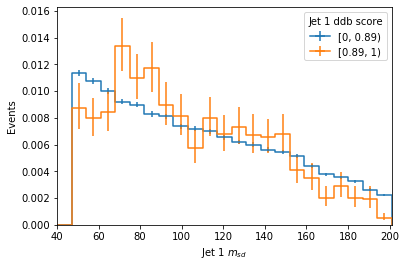

In [29]:
hist.plot1d(templates_pt.integrate('region', 'signal').sum('pt1').integrate('process','QCD'),overlay='ddb1',density=True)
plt.savefig(year+'/plot-all/qcd-msd-all.png')

In [30]:
ptbins = [450, 500, 550, 600, 675, 800, 1200]

In [31]:
os.system('rm '+year+'/pt6-signalregion.root')
fout = uproot.create(year+'/pt6-signalregion.root')
for i,b in enumerate(ptbins[:-1]):
    for p in pmap.keys():  
        h = templates_pt.integrate('region', 'signal').integrate('pt1',int_range=slice(ptbins[i],ptbins[i+1])).integrate('ddb1',int_range=slice(0.89,1)).integrate('process',p)
        fout[p+"_pass_pt"+str(i+1)] = hist.export1d(h)
        h = templates_pt.integrate('region', 'signal').integrate('pt1',int_range=slice(ptbins[i],ptbins[i+1])).integrate('ddb1',int_range=slice(0,0.89)).integrate('process',p)
        fout[p+"_fail_pt"+str(i+1)] = hist.export1d(h)

fout.close()

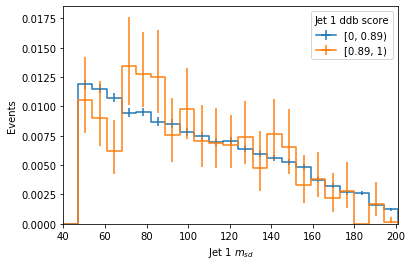

In [32]:
hist.plot1d(templates_pt.integrate('region', 'signal').integrate('pt1',int_range=slice(ptbins[0],ptbins[1])).integrate('process','QCD'),overlay='ddb1',density=True)
plt.savefig(year+'/plot-all/qcd-msd-pt1.png')

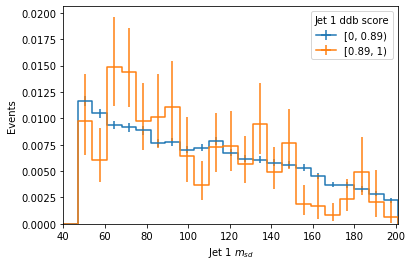

In [33]:
hist.plot1d(templates_pt.integrate('region', 'signal').integrate('pt1',int_range=slice(ptbins[1],ptbins[2])).integrate('process','QCD'),overlay='ddb1',density=True)
plt.savefig(year+'/plot-all/qcd-msd-pt2.png')

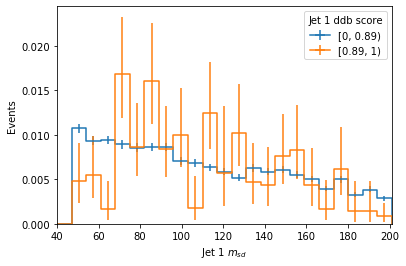

In [34]:
hist.plot1d(templates_pt.integrate('region', 'signal').integrate('pt1',int_range=slice(ptbins[2],ptbins[3])).integrate('process','QCD'),overlay='ddb1',density=True)
plt.savefig(year+'/plot-all/qcd-msd-pt3.png')

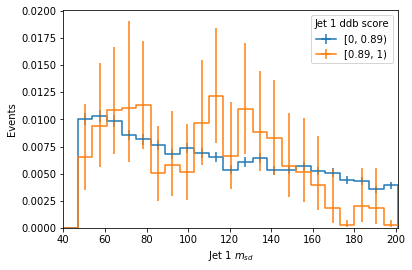

In [35]:
hist.plot1d(templates_pt.integrate('region', 'signal').integrate('pt1',int_range=slice(ptbins[3],ptbins[4])).integrate('process','QCD'),overlay='ddb1',density=True)
plt.savefig(year+'/plot-all/qcd-msd-pt4.png')

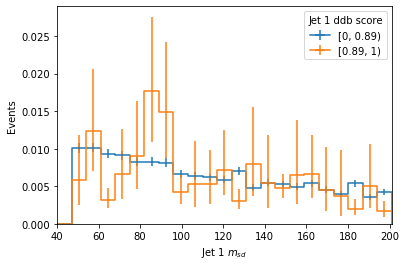

In [36]:
hist.plot1d(templates_pt.integrate('region', 'signal').integrate('pt1',int_range=slice(ptbins[4],ptbins[5])).integrate('process','QCD'),overlay='ddb1',density=True)
plt.savefig(year+'/plot-all/qcd-msd-pt5.png')

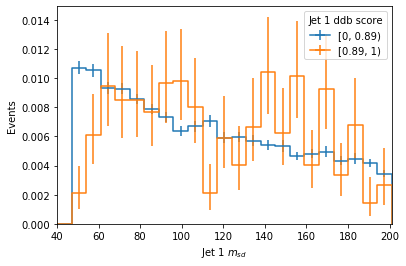

In [37]:
hist.plot1d(templates_pt.integrate('region', 'signal').integrate('pt1',int_range=slice(ptbins[5],ptbins[6])).integrate('process','QCD'),overlay='ddb1',density=True)
plt.savefig(year+'/plot-all/qcd-msd-pt6.png')

In [38]:
mjjbins = [1000,2000,3000,4000]

In [39]:
os.system('rm '+year+'/mjj3-signalregion.root')
fout = uproot.create(year+'/mjj3-signalregion.root')
for i,b in enumerate(mjjbins[:-1]):
    for p in pmap.keys():  
        h = templates_mjj.integrate('region', 'signal').integrate('mjj',int_range=slice(mjjbins[i],mjjbins[i+1])).integrate('ddb1',int_range=slice(0.89,1)).integrate('process',p)
        fout[p+"_pass_mjj"+str(i+1)] = hist.export1d(h)
        h = templates_mjj.integrate('region', 'signal').integrate('mjj',int_range=slice(mjjbins[i],mjjbins[i+1])).integrate('ddb1',int_range=slice(0,0.89)).integrate('process',p)
        fout[p+"_fail_mjj"+str(i+1)] = hist.export1d(h)

fout.close()

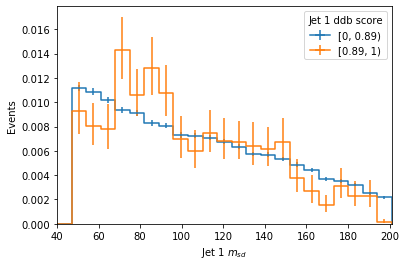

In [40]:
hist.plot1d(templates_mjj.integrate('region', 'signal').integrate('mjj',int_range=slice(mjjbins[0],mjjbins[1])).integrate('process','QCD'),overlay='ddb1',density=True)
plt.savefig(year+'/plot-all/qcd-msd-mjj1.png')

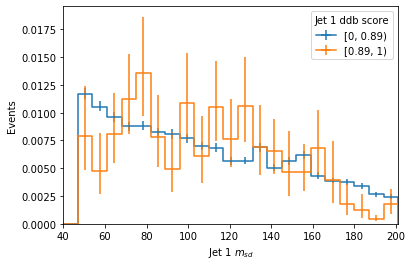

In [41]:
hist.plot1d(templates_mjj.integrate('region', 'signal').integrate('mjj',int_range=slice(mjjbins[1],mjjbins[2])).integrate('process','QCD'),overlay='ddb1',density=True)
plt.savefig(year+'/plot-all/qcd-msd-mjj2.png')

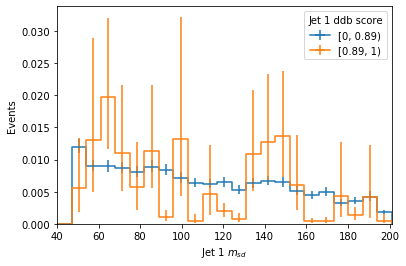

In [42]:
hist.plot1d(templates_mjj.integrate('region', 'signal').integrate('mjj',int_range=slice(mjjbins[2],mjjbins[3])).integrate('process','QCD'),overlay='ddb1',density=True)
plt.savefig(year+'/plot-all/qcd-msd-mjj3.png')

In [44]:
os.system('rm '+year+'/muonCR.root')
fout = uproot.create(year+'/muonCR.root')
for p in pmap.keys():  
    h = templates_pt.sum('pt1').integrate('region', 'muoncontrol').integrate('ddb1',int_range=slice(0.89,1)).integrate('process',p)
    fout[p+"_pass"] = hist.export1d(h)
    h = templates_pt.sum('pt1').integrate('region', 'muoncontrol').integrate('ddb1',int_range=slice(0,0.89)).integrate('process',p)
    fout[p+"_fail"] = hist.export1d(h)

fout.close()